# Using Network Science to Examine the Spread of COVID-19
### By Sandeep Tiwari

Since December 2019, the rapid spread of COVID-19 corona-viruses worldwide has caused more than 7 million infections and more than 400,000 deaths. In this notebook, we will attempt to explore the spread of the novel coronavirus using global cases from January to March, using Network Science and graph theory. 

While machine learning has risen to the center stage as a hot field with universal applications, graphs are becoming central to machine learning these days. Whether you want to predict potential connections in a social network, detect fraud, or understand a businesses customer behavior, graph theory can be used to model and understand these phenomena.


## Imports

In [12]:
# for handling dataframes
import pandas as pd
# for math
import numpy as np
# for data stores
import json

# for data visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pygraphviz
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16
pd.set_option('display.max_columns', None)
# %matplotlib notebook

# for visualizing geo-spatial data
import folium

# for implementing graph theory concepts and visualizing and handling graph/network
import networkx as nx
import community as community_louvain

# used to parse strings for geographical information
from geotext import GeoText
from geopy import geocoders
from geopy.geocoders import Nominatim
import pycountry_convert as pc

# for graphical embedding
from node2vec import Node2Vec
import dgl

from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap

import random
from scipy.stats import powerlaw

import warnings
warnings.filterwarnings('ignore')

## Loading data

This dataset was taken from [Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

The Google Drive link to the original dataset is [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vQU0SIALScXx8VXDX7yKNKWWPKE1YjFlWc6VTEVSN45CklWWf-uWmprQIyLtoPDA18tX9cFDr-aQ9S6/pubhtml)

In [2]:
datafile = 'data/COVID19_line_list_data.tsv'
data = pd.read_csv(datafile, sep='\t')

In [3]:
data.head()

id  case_in_country reporting date  \
0   1              NaN        1/20/20   
1   2              NaN        1/20/20   
2   3              NaN        1/21/20   
3   4              NaN        1/21/20   
4   5              NaN        1/21/20   

                                             summary             location  \
0  First confirmed imported COVID-19 pneumonia pa...  Shenzhen, Guangdong   
1  First confirmed imported COVID-19 pneumonia pa...             Shanghai   
2  First confirmed imported cases in Zhejiang: pa...             Zhejiang   
3  new confirmed imported COVID-19 pneumonia in T...              Tianjin   
4  new confirmed imported COVID-19 pneumonia in T...              Tianjin   

  country  gender   age symptom_onset  If_onset_approximated hosp_visit_date  \
0   China    male  66.0        1/3/20                    0.0         1/11/20   
1   China  female  56.0       1/15/20                    0.0         1/15/20   
2   China    male  46.0        1/4/20                    0.0         1/17/20   
3   China  female  60.0           NaN                    NaN         1/19/20   
4   China    male  58.0           NaN                    NaN         1/14/20   

   international_traveler  domestic_traveler exposure_start exposure_end  \
0                     NaN                NaN       12/29/19       1/4/20   
1                     NaN                NaN            NaN      1/12/20   
2                     NaN                NaN            NaN       1/3/20   
3                     NaN                NaN            NaN          NaN   
4                     NaN                NaN            NaN          NaN   

   traveler  visiting Wuhan  from Wuhan death recovered symptom  \
0       NaN             1.0         0.0     0         0     NaN   
1       NaN             0.0         1.0     0         0     NaN   
2       NaN             0.0         1.0     0         0     NaN   
3       NaN             1.0         0.0     0         0     NaN   
4       NaN             0.0         0.0     0         0     NaN   

                                              source  \
0               Shenzhen Municipal Health Commission   
1  Official Weibo of Shanghai Municipal Health Co...   
2             Health Commission of Zhejiang Province   
3                                           人民日报官方微博   
4                                           人民日报官方微博   

                                                link  
0  http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...  
1  https://www.weibo.com/2372649470/IqogQhgfa?fro...  
2  http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...  
3        https://m.weibo.cn/status/4463235401268457?  
4        https://m.weibo.cn/status/4463235401268457?

In [4]:
data.shape

(3374, 23)

### Metadata

* `id`: case id
* `case_in_country`: number of cases in same country as patient
* `reporting date`: date case was reported
* `summary`: brief summary of activity of patient leading up to diagnosis
* `location`: city in which patient was diagnosed
* `country`: country in which patient was diagnosed
* `gender`: gender of patient
* `age`: age of patient
* `symptom_onset`: date at which patient first felt symptoms
* `If_onset_approximated`:
* `hosp_visit_date`: date patient visited hospital
* `international_traveler`: binary (0: no, 1: yes) variable describing if patient recently travelled internationally
* `domestic_traveler`: binary (0: no, 1: yes) variable describing if patient recently travelled domestically
* `exposure_start`: date patient was first exposed to virus
* `exposure_end`: date patient's exposure to virus ended
* `traveler`: binary (0: no, 1: yes) variable describing if patient travels
* `visiting Wuhan`: binary (0: no, 1: yes) variable describing if patient visited Wuhan
* `from Wuhan`: binary (0: no, 1: yes) variable describing if patient is from Wuhan
* `death`: date when patient died
* `recovered`: date when patient recovered
* `symptom`: list of patient's symptoms
* `source`: source from which case is reported
* `link`: link to source

### Nullity

In [5]:
data.isna().sum()

id                           0
case_in_country            197
reporting date               1
summary                      5
location                    81
country                      0
gender                    1689
age                       1867
symptom_onset             2690
If_onset_approximated     2719
hosp_visit_date           2754
international_traveler    2548
domestic_traveler         2572
exposure_start            3180
exposure_end              2886
traveler                  2714
visiting Wuhan            1768
from Wuhan                1772
death                     1755
recovered                 1768
symptom                   3036
source                    1768
link                      1752
dtype: int64

We can see that this dataframe is fairly sparse, however the columns that we intend to use to construct our network (`summary`, `location` and `country`) is mostly available to us

### Some Preprocessing

In [6]:
# imputing missing values
data["case_in_country"].fillna(0, inplace=True)
data["summary"].fillna("", inplace=True)
data["location"].fillna("", inplace=True)
data["from Wuhan"].fillna(0, inplace=True)

In [7]:
def country_to_continent(country):
    """
    Given the country name, we will be able to find it's corresponding continent
    """
    cont_map = {'AS':'Asia', 'AF': 'Africa', 'EU':'Europe', 
                'NA':'North America', 'OC':'Australia', 'SA':'South America'}
    if country != "":
        if country == "UAE":
            country = "United Arab Emirates"
        if country == "UK":
            country = "United Kingdom"
        if country == "Phillipines":
            country = 'Philippines'
        country_code = pc.convert_countries.country_name_to_country_alpha2(country)
        continent_code = pc.convert_country_alpha2_to_continent_code.country_alpha2_to_continent_code(country_code)
        return cont_map[continent_code]
    return ""


In [8]:
data["continent"] = data['country'].apply(country_to_continent)

In [9]:
cont_map = {'Asia': 0, 'Africa': 1, 'Australia': 2, 'Europe': 3, 'North America': 4, 'South America': 5, '':6}
data['continent_code'] = data["continent"].map(cont_map)
data['continent_code'] = data['continent_code'].astype(int)

In [10]:
data = data[['id', 'case_in_country', 'reporting date', 'summary', 'location',
 'country', 'continent', 'continent_code', 'gender', 'age', 'symptom_onset', 'If_onset_approximated',
 'hosp_visit_date', 'international_traveler', 'domestic_traveler',
 'exposure_start', 'exposure_end', 'traveler', 'visiting Wuhan',
 'from Wuhan', 'death', 'recovered', 'symptom', 'source', 'link']]

In [11]:
data.dtypes

id                          int64
case_in_country           float64
reporting date             object
summary                    object
location                   object
country                    object
continent                  object
continent_code              int64
gender                     object
age                       float64
symptom_onset              object
If_onset_approximated     float64
hosp_visit_date            object
international_traveler    float64
domestic_traveler         float64
exposure_start             object
exposure_end               object
traveler                  float64
visiting Wuhan            float64
from Wuhan                float64
death                      object
recovered                  object
symptom                    object
source                     object
link                       object
dtype: object

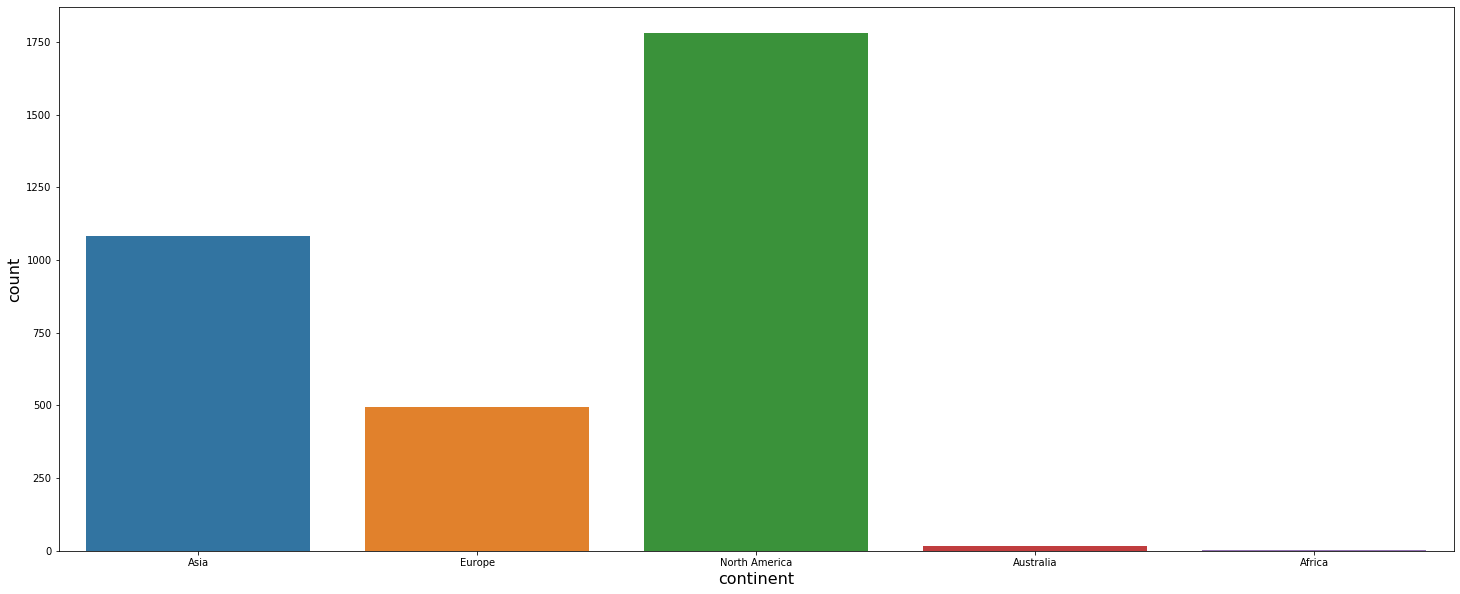

In [13]:
sns.countplot(data=data, x='continent');

## Bipartite graph of coronavirus network

Building a bipartite graph is a start in constructing the network, as a whole. If we can produce a bipartite coloring, we might be able to differentiate which cities are active sites of contracting the virus, and to which cities it is being brought to.


In [14]:
def build_bipartite(dta):
    color_map = color_map = {"":'#f09494', "Asia":'#eebcbc', "Africa":'#72bbd0', "Europe":'#91f0a1',
                             "North America":'#629fff', "Australia":'#bcc2f2', "South America":'#eebcbc'}
    G = nx.Graph()
    for i, row in dta.iterrows():
        location = row["location"]
        country = row["country"]
        places = GeoText(row["summary"])
        cities = set(places.cities)
    
        G.add_node(location, bipartite=0, nodecolor=color_map[row['continent']])
        for city in cities:
            if city != "Wuhan":
                G.add_node(city, bipartite=1, nodecolor=color_map[row['continent']])
                G.add_edge(location, city)
        if dta["visiting Wuhan"][i] == 1 or dta["from Wuhan"][i] == 1:
            G.add_node("Wuhan", bipartite=1, nodecolor=color_map['Asia'])
            G.add_edge(location, "Wuhan")
    return G

In [15]:
B = build_bipartite(data)

After building our network, we should check the number of nodes and edges, using `nx.info(G)`, which also shows the average degree. The **degree** of a node in an undirected graph is the number of nodes it is connected to. So the average degree is the average of all the nodes' degrees.

In [16]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 455
Number of edges: 443
Average degree:   1.9473


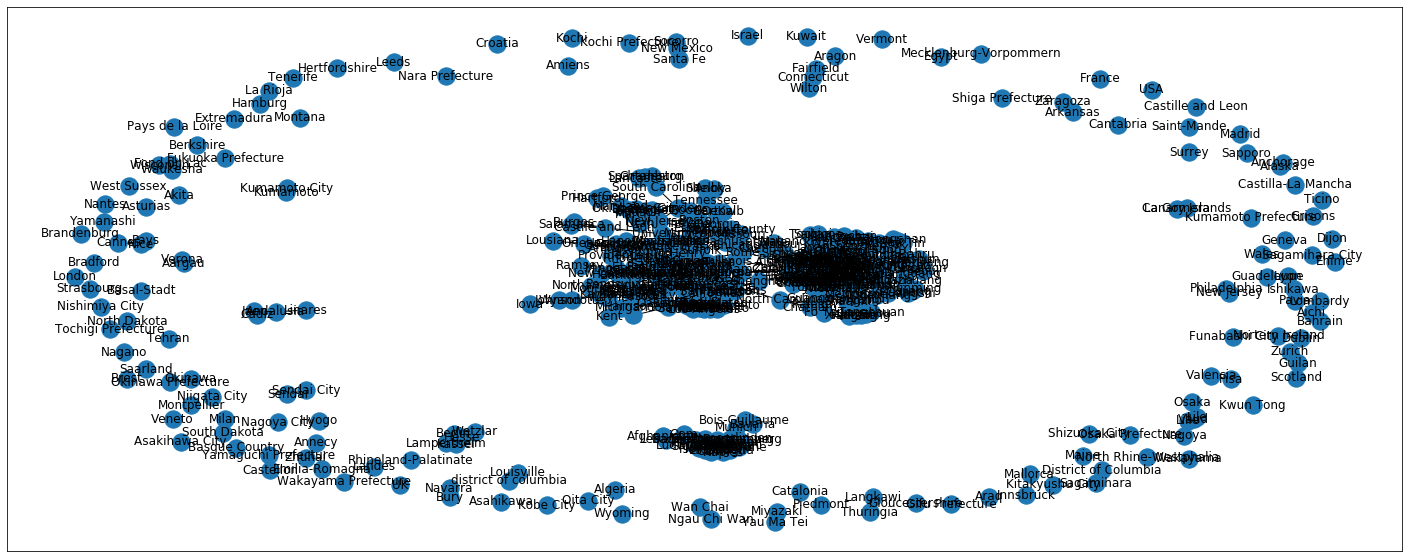

In [18]:
nx.draw_networkx(B)

A network is **connected** if there is a path between every pair of vertices. But this tag network is not connected, which means there are some isolated nodes or isolated subgraphs. A **connected component** is the maximal connected subgraph of a graph.

In [19]:
nx.is_connected(B)

False

Unfortunately, because our graph is not connected, we cannot perform a bipartite coloring. Ideally, if we are able to collect more data, we can create a fully connected network. However, this might be unrealistic given the number of cases we are working with, and the fact that this is real-world data

In [20]:
# number of connected components
nConnectedComponents = nx.number_connected_components(B)
nConnectedComponents

136

In [21]:
# largest connected component
max_connected_component = max([c for c in nx.connected_components(B)], key=len)
max_connected_component


{'',
 'Aichi Prefecture',
 'Alameda',
 'Alappuzha',
 'Albany',
 'Ankang',
 'Anoka',
 'Arizona',
 'Arlington',
 'Asia',
 'Bartow',
 'Beihai',
 'Beijing',
 'Belgium',
 'Bergen',
 'Boone',
 'Bordeaux',
 'Boston',
 'Boulder',
 'Burgos',
 'Burlington',
 'California',
 'Camden',
 'Castile and Leon',
 'Changchun',
 'Changsha',
 'Charleston',
 'Charlotte',
 'Chatham',
 'Chengdu',
 'Chiba',
 'Chiba Prefecture',
 'Chicago',
 'Chongqing',
 'Colorado',
 'Dallas',
 'Davis',
 'Dazhou',
 'DeKalb',
 'Delaware',
 'Denver',
 'Douglas',
 'Eagle',
 'El Paso',
 'Essex',
 'Fairfax',
 'Florida',
 'Fo Tan',
 'Frankfurt',
 'Fresno',
 'Fujian',
 'Fushun',
 'Gansu',
 'Georgetown',
 'Georgia',
 'Gold Coast',
 'Grafton',
 'Guangxi',
 'Guangzhou',
 'Guizhou',
 'Haneda',
 'Hangzhou',
 'Hanoi',
 'Hanover',
 'Hanzhong',
 'Harrison',
 'Harrisonburg',
 'Hartford',
 'Hawaii',
 'Hebei',
 'Hechi, Guangxi',
 'Heilongjiang',
 'Henan',
 'Ho',
 'Ho Chi Minh City',
 'Hokkaido',
 'Hong Kong',
 'Honolulu',
 'Houston',
 'Huanggang

## Cliques

In the real world, we call groups of people who are closely connected to each other, but not connected to people outside the group, cliques. In network theory, a **clique** is defined as a maximal complete subgraph of a graph where each node is connected to all other nodes. The word 'maximal' means that if we add another node to the clique, the clique will cease to be a clique.

In [22]:
cliques = list(nx.find_cliques(B))
print(len(cliques))

460


In [23]:
for clique in cliques:
    print(clique)

['', 'Solano']
['', 'Kent']
['Shenyang', 'Liaoning']
['Leeds']
['Wales']
['Saitama', 'Japan']
['Kwai Chung', 'Shenzhen']
['Kwai Chung', 'Tokyo']
['Pavia', 'Lombardy']
['Zaragoza']
['Saint-Mande']
['Cantabria']
['Sendai', 'Sendai City']
['Niigata City']
['Shenzhen', 'NSW']
['Shenzhen', 'Hong Kong']
['Shenzhen', 'Shenzhen, Guangdong']
['Huanggang', 'Hubei']
['Kentucky', 'Harrison']
['Kentucky', 'Montgomery']
['Kentucky', 'Jefferson']
['Salamanca', 'Castile and Leon']
['Seattle', 'North Carolina']
['Seattle', 'Washington', 'California']
['Seattle', 'Washington', 'Oklahoma']
['Santa Cruz', 'California']
['Kumamoto City', 'Kumamoto']
['Dublin', 'Nortern Ireland']
['Camden', 'Georgia']
['Camden', 'South Carolina']
['Camden', 'New Jersey']
['Nagano Prefecture', 'Tokyo']
['Trumbull', 'Ohio']
['Qingdao', 'Shandong']
['Qingdao', 'South Korea']
['Ventura', 'California']
['Houston', 'Texas']
['March', 'New Jersey']
['Surrey']
['Nassau', 'Florida', 'New York']
['Yau Ma Tei']
['Munich', 'Bavaria']
[

In [24]:
max(cliques, key=len)

['Seattle', 'Washington', 'California']

## Coronavirus Network Cliques

For each case, there's a location (city) in the network. So we can check the cliques that contains that node. Coronavirus network for a node is the subgraph containing that node, and all it's neighbors with a specified depth range.

For example, we can check our network for Wuhan, which means that we get a subgraph containing Wuhan, and all it's direct neighbors, which are 1 edge away from it, and also nodes which are 2 edge hops away from Wuhan.

This network can be used for checking shortest paths or generally conducting analysis of who is connected to whom, but cliques are helpful because it shows us the data in a more granular way. This is particularly helpful in social networks.

In [25]:
nx.algorithms.clique.cliques_containing_node(B, "Wuhan")

[['Wuhan', 'Liaoning'],
 ['Wuhan', 'Shenzhen, Guangdong'],
 ['Wuhan', 'Vietnam'],
 ['Wuhan', 'Guizhou'],
 ['Wuhan', 'Shanxi (陕西)'],
 ['Wuhan', 'Thanh Hoa'],
 ['Wuhan', 'Bordeaux'],
 ['Wuhan', 'Massachusetts'],
 ['Wuhan', 'Preah Sihanouk Province'],
 ['Wuhan', 'Singapore'],
 ['Wuhan', 'Wuhan, Hubei'],
 ['Wuhan', 'South Australia'],
 ['Wuhan', 'Shanghai', 'Vancouver'],
 ['Wuhan', 'Shanghai', 'California'],
 ['Wuhan', 'Toronto'],
 ['Wuhan', 'Yunnan'],
 ['Wuhan', 'Xinjiang'],
 ['Wuhan', 'Gansu'],
 ['Wuhan', 'Tianjin', 'Beijing'],
 ['Wuhan', 'Ningxia'],
 ['Wuhan', 'Belgium'],
 ['Wuhan', 'Sichuan'],
 ['Wuhan', 'Kyoto'],
 ['Wuhan', 'Zabaikalsky'],
 ['Wuhan', 'Ho Chi Minh City'],
 ['Wuhan', 'Hanoi'],
 ['Wuhan', 'Hubei'],
 ['Wuhan', 'Shanxi'],
 ['Wuhan', 'Alappuzha'],
 ['Wuhan', 'Chongqing', 'Thailand'],
 ['Wuhan', 'Tyumen'],
 ['Wuhan', 'Zhejiang'],
 ['Wuhan', 'Jonkoping'],
 ['Wuhan', 'Washington', 'California'],
 ['Wuhan', 'Hebei'],
 ['Wuhan', 'Sri Lanka'],
 ['Wuhan', 'Kanagawa'],
 ['Wuhan', '

In [26]:
nx.algorithms.clique.cliques_containing_node(B, "California")

[['Seattle', 'Washington', 'California'],
 ['Santa Cruz', 'California'],
 ['Ventura', 'California'],
 ['San Benito', 'California'],
 ['Los Angeles', 'California'],
 ['Orange', 'California'],
 ['Wuhan', 'Shanghai', 'California'],
 ['Wuhan', 'Washington', 'California'],
 ['San Antonio', 'California'],
 ['Sacramento', 'California'],
 ['Colorado', 'Denver', 'California'],
 ['Imperial', 'California'],
 ['Oakland', 'California'],
 ['Florida', 'Washington', 'California'],
 ['Madera', 'California'],
 ['Santa Clara', 'California'],
 ['Solano', 'California'],
 ['San Francisco', 'California'],
 ['San Diego', 'California'],
 ['Riverside', 'California'],
 ['Alameda', 'California'],
 ['Napa', 'California'],
 ['Tulare', 'California'],
 ['Fresno', 'California'],
 ['San Mateo', 'California']]

## Degree Distribution

In [27]:
from networkx.drawing.nx_agraph import graphviz_layout

def degree_hist(G, bins=85):
#     matplotlib.rcParams['figure.figsize'] = (5, 5)
    p = dict(nx.degree(G))
    return plt.hist(x=list(p.values()), 
             bins=bins, 
             color='#0504aa', 
             alpha=0.7
            )
    

For checking the degree distribution of the graph plotting the list containing degrees for each node works. In this coronavirus, clearly most cases have only about 1 neighbor, while some cases are linked to more than 10-20 cities

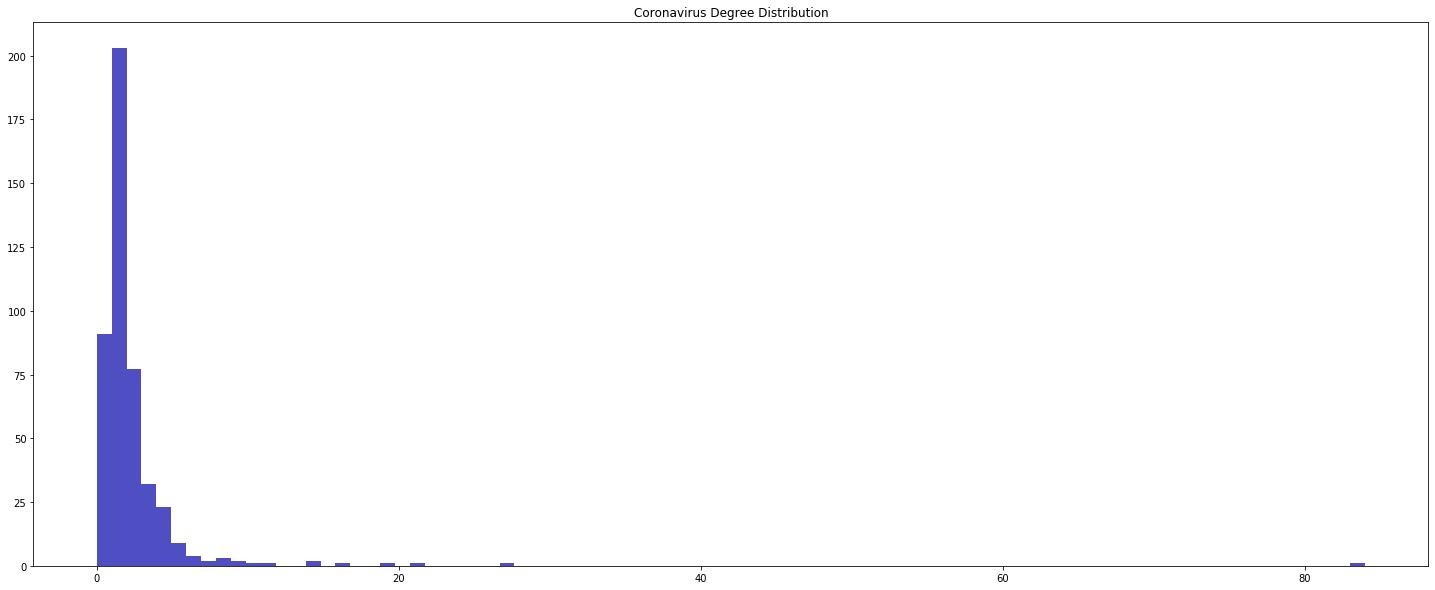

In [28]:
cnts, bins, patches = degree_hist(B)
plt.title("Coronavirus Degree Distribution");

Upon examining this plot, we can see how the degree distribution decreases, exponentially. This noticeable power law decay suggests that our network is a scale free network.

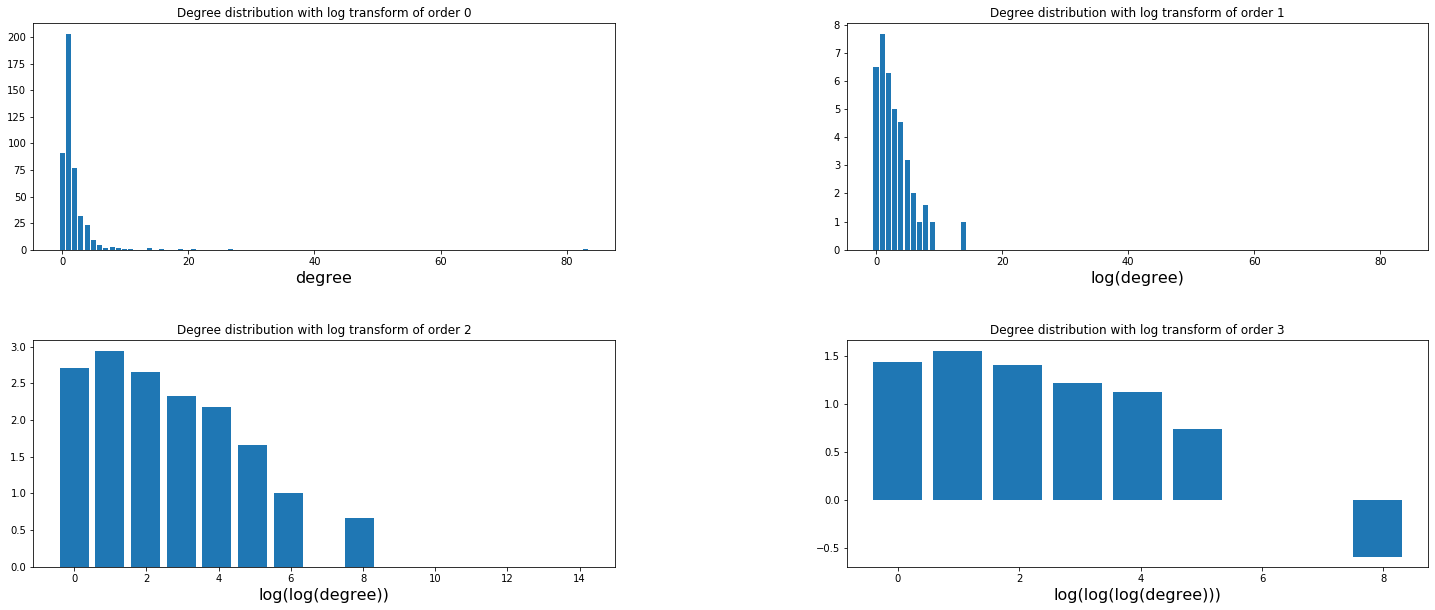

In [29]:
log_cnts = cnts
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ind = 1
for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(2, 2, ind)
        plt.bar(x=bins[:-1], height=log_cnts)
        plt.xlabel('{}degree{}'.format('log('*(ind-1), ')'*(ind-1)));
        plt.title('Degree distribution with log transform of order ' + str(ind-1));
        log_cnts = np.log2(log_cnts)
        ind += 1

As the figure above indicates, for the degree distribution of our network, the power law persists in our degree deistribution for about two orders of magnitude, prompting us to call the coronavirus graph a scale-free network.

## Visualizing Coronavirus Network

Since it's possible to draw the subgraph of a graph, a subgraph containing the nodes for the cases only can be visualized. In thie visualization, it's possible to see the different clusters around each city

In [42]:
# this is the old method, used to create first graph and cache locations for later use
from time import sleep
def buildMap(dta):
    locs = set()
    G = nx.Graph()
    
    locs.add("Wuhan")
    geolocator = Nominatim(user_agent="account_username")
    wuhan = geolocator.geocode("Wuhan")
    G.add_node("Wuhan", pos=(wuhan.longitude, wuhan.latitude))
    
    for i, row in dta.iterrows():
        location = row["location"]
        country = row["country"]
        if location not in locs:
            if location != "" or country != "":
                loc = geolocator.geocode(location + ' ' + country) # gets geographic information of location
                try:
                    G.add_node(location, pos=(loc.longitude, loc.latitude)) # add location at (long, lat) to G
                except:
                    G.add_node(location, pos=(0, 0)) # else just add location at (0, 0) to G
                locs.add(location)
                sleep(1)
        places = GeoText(row["summary"])
        cities = set(places.cities)
        for city in cities:
            if city != "Wuhan": 
                if city not in locs:
                    loc = geolocator.geocode(city)
                    try:
                        G.add_node(city, pos=(loc.longitude, loc.latitude))
                    except:
                        G.add_node(city, pos=(0, 0))
                    locs.add(city)
                    sleep(1)
                G.add_edge(location, city) # add edge from location to city to G
        if row["visiting Wuhan"] == 1 or row["from Wuhan"] == 1: # handles cases visited/from Wuhan
            G.add_edge(location, "Wuhan")
        
    return G

In [57]:
# G = buildMap(data)

Below we are saving the map of locations to coordinates generated by `buildMap` above to a json file. This will serve as cache for later use, so we can more quickly build this graph in the future

In [50]:
# d = nx.get_node_attributes(G, 'pos')
# json_file = json.dumps(d)
# f = open("locations3.json", "w")
# f.write(json_file)
# f.close()

Here we are building a graph of the nodes, positioned in their (longitude, latitude), so that we can more easily visualize the spread at a global level. We have alread cached these coordinates (generated from `buildMap` above) to quickly build the graph, but we have also included the labels of each city, to see from where each connection is being made.

In [30]:
def build_map_with_cache(dta):
    with open("locations3.json") as json_file:
        d = json.load(json_file)
    G = nx.Graph()
    for i, row in dta.iterrows():
        long, lat = d[row["location"]]
        G.add_node(row["location"], pos=(long, lat))
        places = GeoText(row["summary"])
        cities = set(places.cities)
        for city in cities:
            if city != "Wuhan":
                long, lat = d[city]
                G.add_node(city, pos=(long, lat))
                G.add_edge(row["location"], city)
        if row["visiting Wuhan"] == 1 or row["from Wuhan"] == 1:
            long, lat = d["Wuhan"]
            G.add_node("Wuhan", pos=(long, lat))
            G.add_edge(row["location"], "Wuhan")
    return G

In [31]:
G = build_map_with_cache(data)

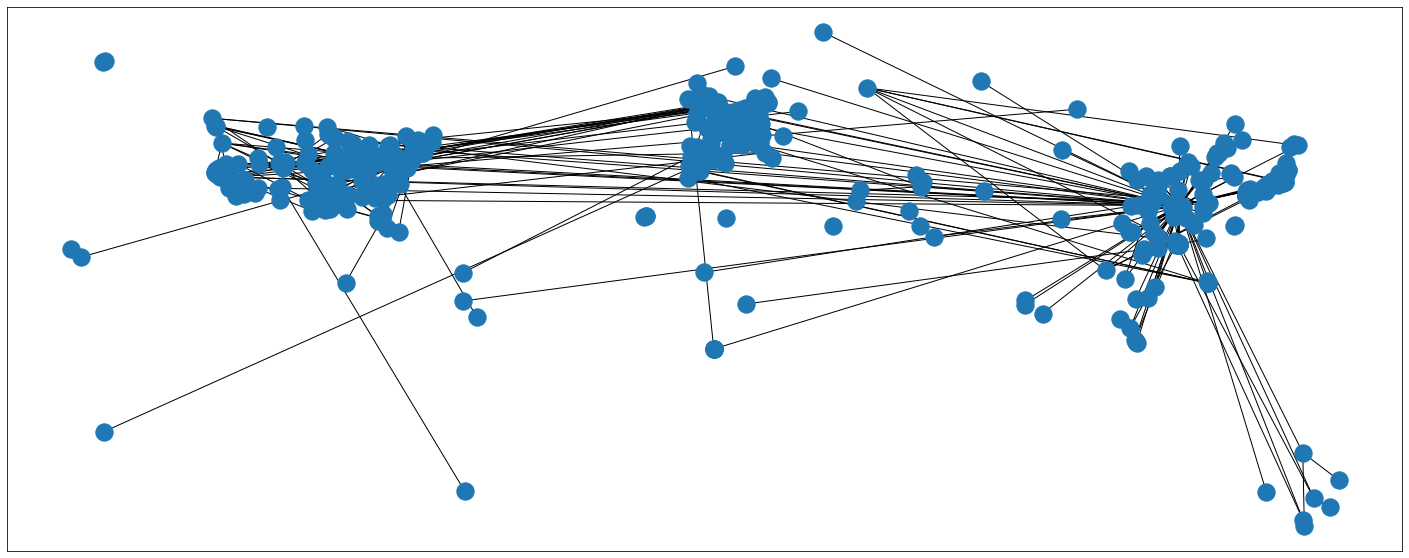

In [54]:
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'), with_labels=False, edge_color='black')

In [33]:
def degree_plot(G, pos=None):
    """
    A simple utility to draw the graph, highlighting the degree of each node.
    """
    if pos == None:
        pos = graphviz_layout(G)
    fig = plt.figure()
    cmap = plt.cm.YlOrRd
    p = dict(nx.degree(G))
    
    degree_list = list(p.values())
    node_size = [5*pow(x, 1.5) for x in degree_list]
    ma, mi = max(degree_list), min(degree_list)
    rng = ma-mi
    normalized = [.6 + (.4*(x-mi))/(1.*rng) for x in degree_list]
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=node_size, 
                           alpha=normalized, 
                           node_color=list(p.values()),
                           cmap=cmap,
                          )
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_size=node_size, 
                           alpha=0.1, 
                           edge_color='black',
                          )
    sm=plt.cm.ScalarMappable(
        cmap=cmap, 
        norm=plt.Normalize(vmin=mi, vmax=ma))
    fig.colorbar(sm)

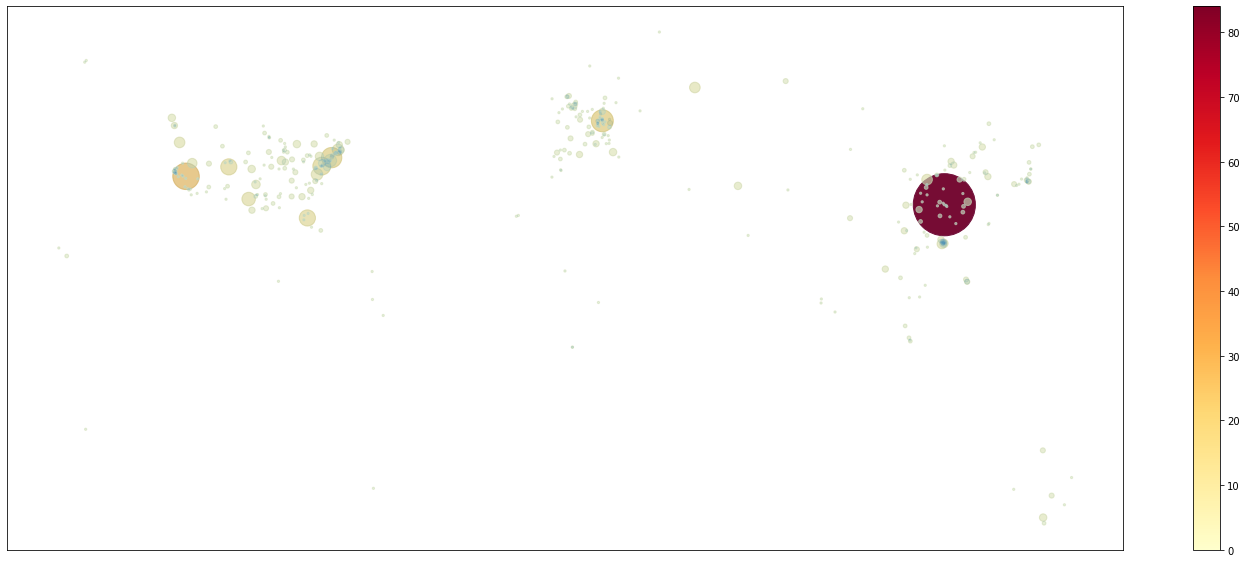

In [34]:
degree_plot(G, nx.get_node_attributes(G, 'pos'))

Now that we are able to map each of the nodes to their corresponding locations on a world map, let us look at the degrees of the cities

In [35]:
sorted(list(G.degree), key=lambda x: x[1], reverse=True)

[('Wuhan', 84),
 ('California', 27),
 ('Baden-Wuerttemberg', 21),
 ('New York', 19),
 ('Washington', 16),
 ('Florida', 14),
 ('Colorado', 14),
 ('Texas', 11),
 ('New Jersey', 10),
 ('Massachusetts', 9),
 ('Virginia', 9),
 ('Shaanxi', 8),
 ('Tokyo', 8),
 ('Oregon', 8),
 ('Macau', 7),
 ('Nevada', 7),
 ('Illinois', 6),
 ('Pennsylvania', 6),
 ('Oklahoma', 6),
 ('Hong Kong', 6),
 ('Shanghai', 5),
 ('Maryland', 5),
 ('Delaware', 5),
 ('Rome', 5),
 ('Vancouver', 5),
 ('Kansas', 5),
 ('Michigan', 5),
 ('Victoria', 5),
 ('Qom', 5),
 ('Shenzhen', 4),
 ('Tianjin', 4),
 ('Chongqing', 4),
 ('Sichuan', 4),
 ('Beijing', 4),
 ('Yunnan', 4),
 ('Jilin', 4),
 ('Nice', 4),
 ('Japan', 4),
 ('Guangzhou', 4),
 ('South Korea', 4),
 ('San Antonio', 4),
 ('New Hampshire', 4),
 ('Georgia', 4),
 ('Seattle', 4),
 ('Boston', 4),
 ('Douglas', 4),
 ('South Carolina', 4),
 ('Essex', 4),
 ('Toronto', 4),
 ('Hesse', 4),
 ('Barcelona', 4),
 ('Kowloon', 4),
 ('Shandong', 3),
 ('Liaoning', 3),
 ('Bordeaux', 3),
 ('Paris', 

## Community Detection

### Louvain Method

Let us look for the communities within our network. A **community** is a set of connected nodes. There is no universal definition that one can give, but the nodes within a community should be densely connected.

We will utilize the *python-louvain* library, which employs the **Louvain method** of finding communities in networks. This method outperforms other methods in terms of compute time, allowing us to analyze networks of unprecedented size. It has also proven to be very accurate

This method first looks for "small" communities, then aggregates nodes of the same community and builds a new network whose nodes are these communities. These steps repeat until a maximum modularity is attained. **Modularity** is a measure of how well groups have been partitioned into clusters

From this program, we get several partitions. We first get small communities, and then  find larger and larger communities due to the aggregation mechanism.

In [36]:
def visualize_communities(G):
    locs = nx.get_node_attributes(G, 'pos')

    partition = community_louvain.best_partition(G)

    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, locs, partition.keys(), node_size=40,
                           cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, locs, alpha=0.5);
    plt.title("Communities in Coronavirus network");

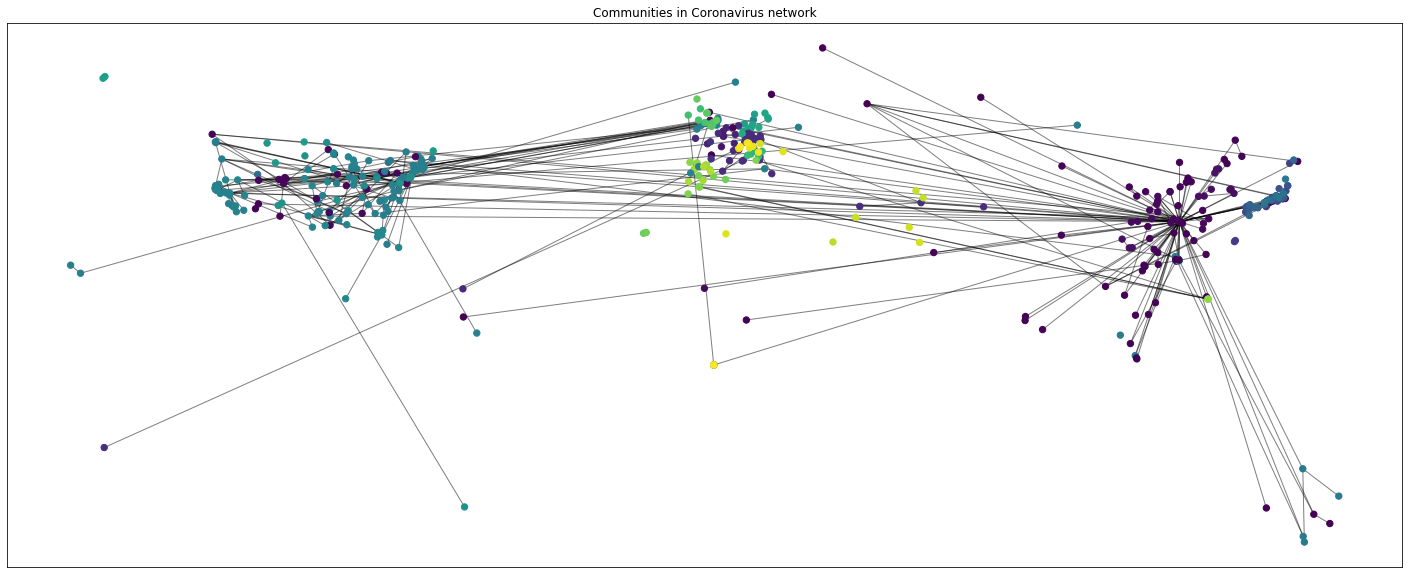

In [37]:
visualize_communities(G)

## Clustering

### Clustering Coefficients

The clustering coefficients measures how well two nodes tend to **cluster** together. The local clustering coefficient is a ratio of the number of triangles centered at node $i$ over the number of triples centered at node $i$. In some sense, it measure how close a node $i$ and its neighbors are to being a complete graph.

For our graph, we can use `networkx` to easily compute the clustering coefficient

In [38]:
# List of local clustering coefficients
clustering_coeffs = list(nx.clustering(G).values())
sorted(nx.clustering(G).items(), key=lambda x:x[1], reverse=True)

[('Tianjin', 1.0),
 ('Chongqing', 1.0),
 ('Beijing', 1.0),
 ('Hokkaido', 1.0),
 ('Malaysia', 1.0),
 ('Taiwan', 1.0),
 ('Thailand', 1.0),
 ('Nassau', 1.0),
 ('Denver', 1.0),
 ('Bergamo', 1.0),
 ('Barcelona', 1.0),
 ('Shanghai', 0.6666666666666666),
 ('Rockland', 0.6666666666666666),
 ('Chiba Prefecture', 0.3333333333333333),
 ('Seattle', 0.3333333333333333),
 ('Vancouver', 0.3333333333333333),
 ('Macau', 0.3),
 ('Tokyo', 0.2),
 ('Japan', 0.16666666666666666),
 ('New Hampshire', 0.16666666666666666),
 ('Oklahoma', 0.16666666666666666),
 ('Illinois', 0.06666666666666667),
 ('Hong Kong', 0.06666666666666667),
 ('Texas', 0.05555555555555555),
 ('Nevada', 0.047619047619047616),
 ('Florida', 0.045454545454545456),
 ('Washington', 0.04395604395604396),
 ('New York', 0.03676470588235294),
 ('Colorado', 0.015151515151515152),
 ('California', 0.014245014245014245),
 ('Baden-Wuerttemberg', 0.004761904761904762),
 ('Wuhan', 0.003155479059093517),
 ('Shenzhen, Guangdong', 0),
 ('Shenzhen', 0),
 ('Zh

Our global clustering coefficient will be

In [39]:
np.mean(clustering_coeffs)

0.032380946106267565

### Clustering data using UMAP

In [133]:
umap_data = data.select_dtypes([int, float])
umap_data.fillna(0, inplace=True)
standard_embedding = umap.UMAP(random_state=42).fit_transform(umap_data)

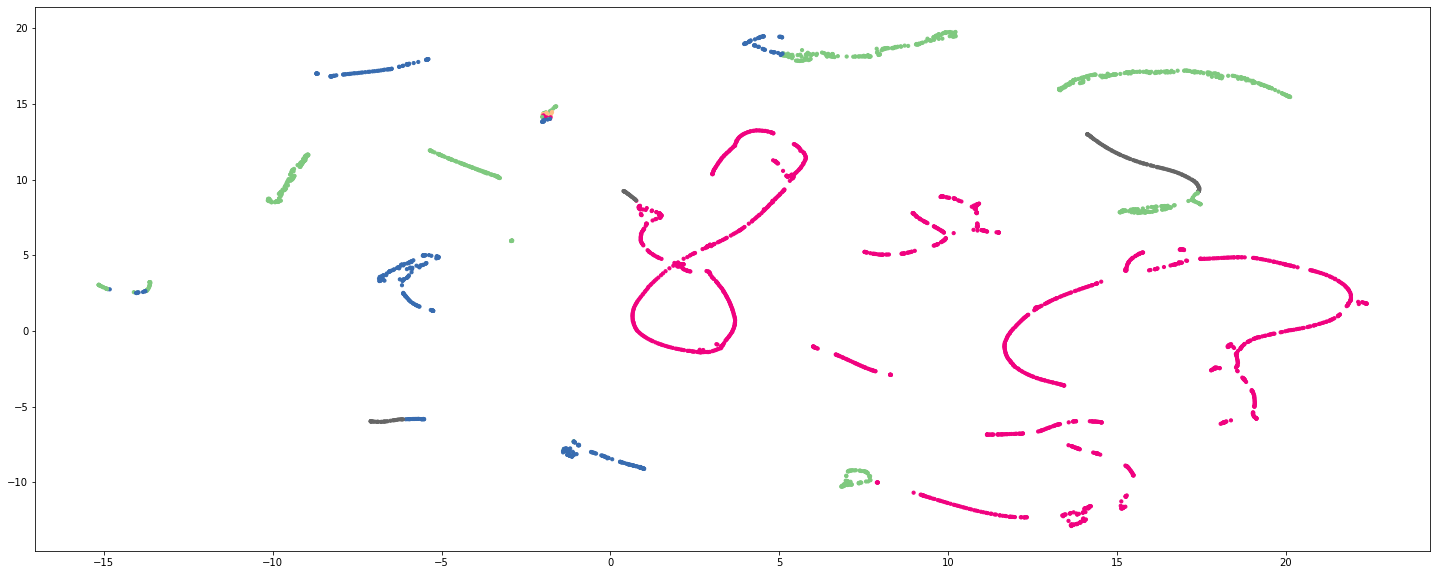

In [134]:

plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], 
            c=data["continent_code"], s=10.0, cmap='Accent');


### Clustering data using tSNE

In [135]:
tsne_df = data.copy()
tsne_df = tsne_df.select_dtypes([int, float])
tsne_df.fillna(0, inplace=True)
rndperm = np.random.permutation(len(tsne_df))

In [136]:
df_subset = tsne_df.loc[rndperm,:].copy()
data_subset = df_subset.values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [7.93803240e-01 2.05651784e-01 5.42535419e-04]


In [137]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3397 samples in 0.002s...
[t-SNE] Computed neighbors for 3397 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3397
[t-SNE] Computed conditional probabilities for sample 2000 / 3397
[t-SNE] Computed conditional probabilities for sample 3000 / 3397
[t-SNE] Computed conditional probabilities for sample 3397 / 3397
[t-SNE] Mean sigma: 16.195479
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.828537
[t-SNE] KL divergence after 300 iterations: 0.599155


In [138]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['tsne-2d-three'] = tsne_results[:,2]

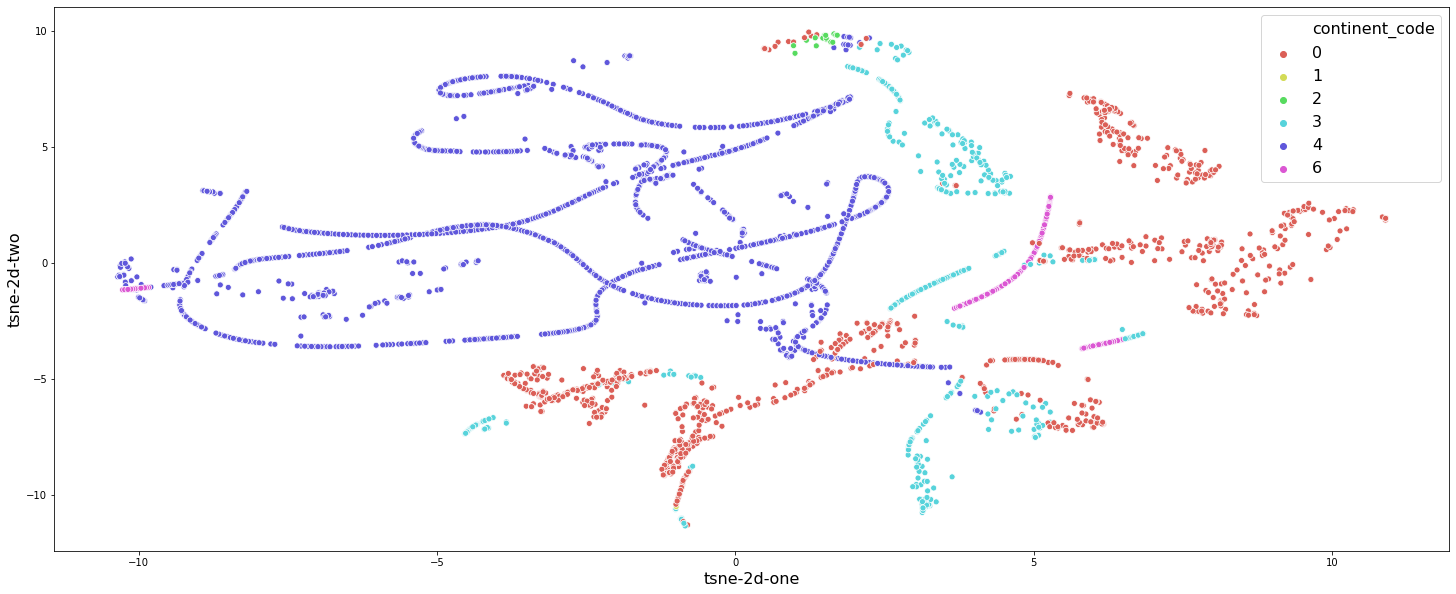

In [139]:
sns.scatterplot(x="tsne-2d-one", 
                y="tsne-2d-two",
                hue="continent_code",
                palette=sns.color_palette("hls", 6),
                data=df_subset,
                legend="full"
               );

''

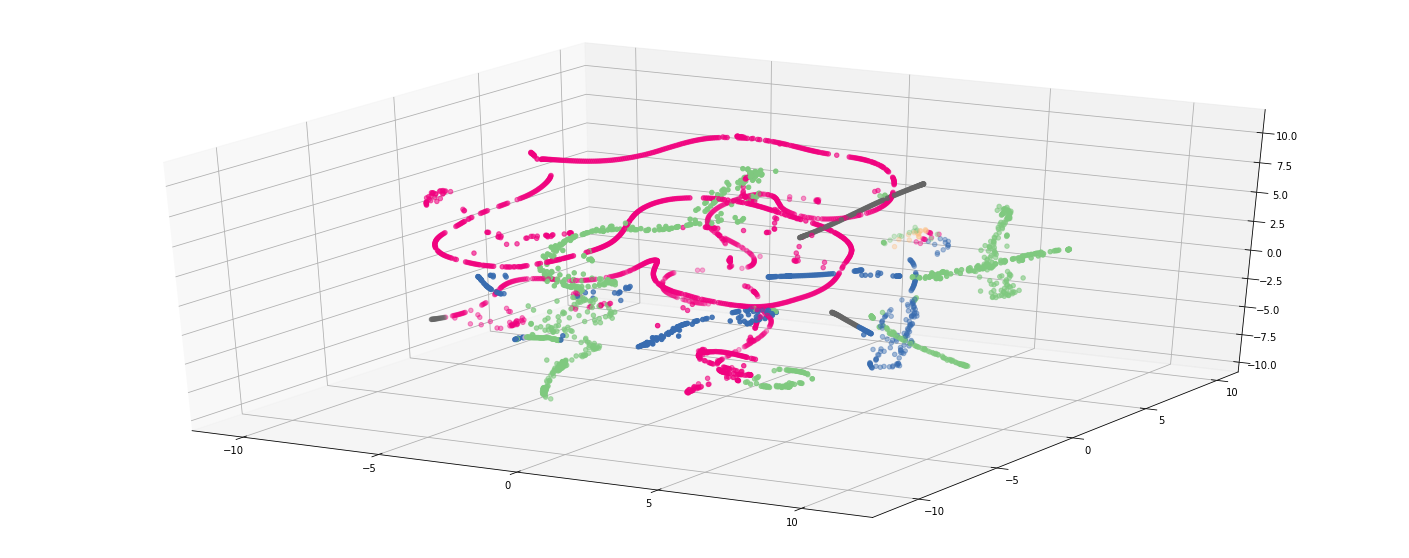

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df_subset["tsne-2d-one"], 
           ys=df_subset["tsne-2d-two"], 
           zs=df_subset["tsne-2d-three"], 
           c=df_subset["continent_code"],
           cmap="Accent"
          )
;

### Clustering using kPCA

In [141]:
kpca_df = data.copy()
kpca_df = kpca_df.select_dtypes([int, float])
kpca_df.fillna(0, inplace=True)
X = kpca_df.drop("continent_code", axis=1)
y = kpca_df["continent_code"]

In [142]:
# Perform Kernel PCA
kernel_pca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True, gamma=1/X.shape[0])
X_kernel_pca = kernel_pca.fit_transform(X)

xs = X_kernel_pca[:, 0]
ys = X_kernel_pca[:, 1]
zs = X_kernel_pca[:, 2]

''

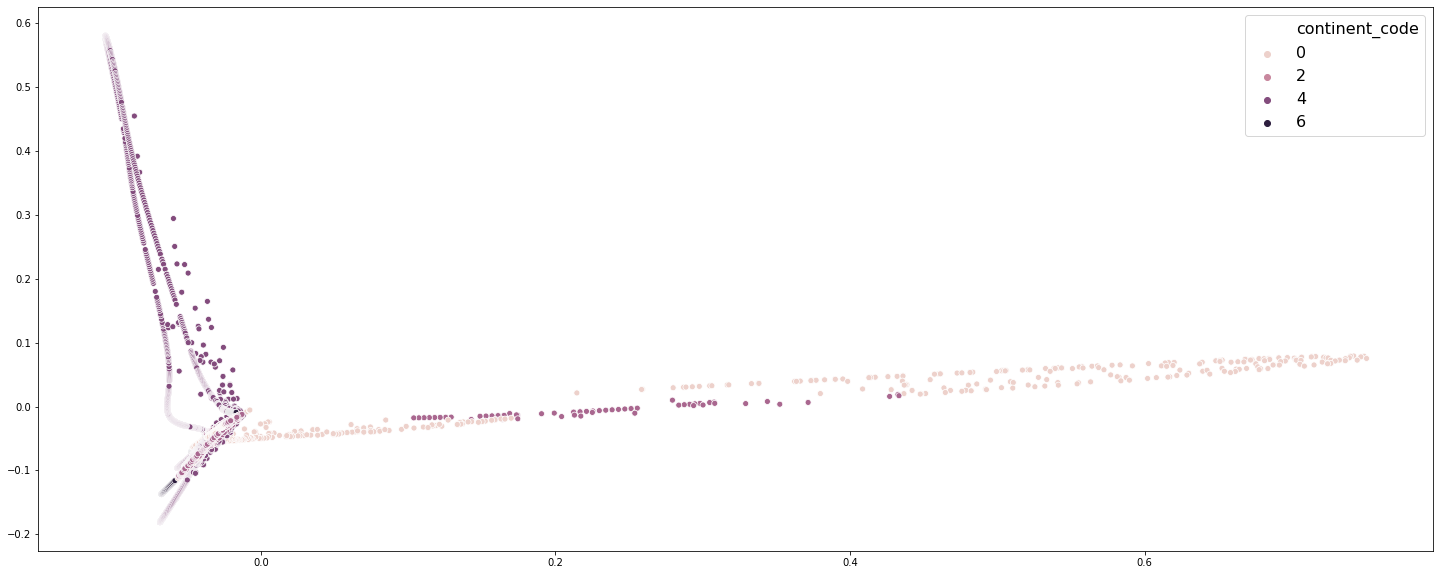

In [143]:
sns.scatterplot(x=xs, 
                y=ys, 
                hue=data["continent_code"]
               )
;

''

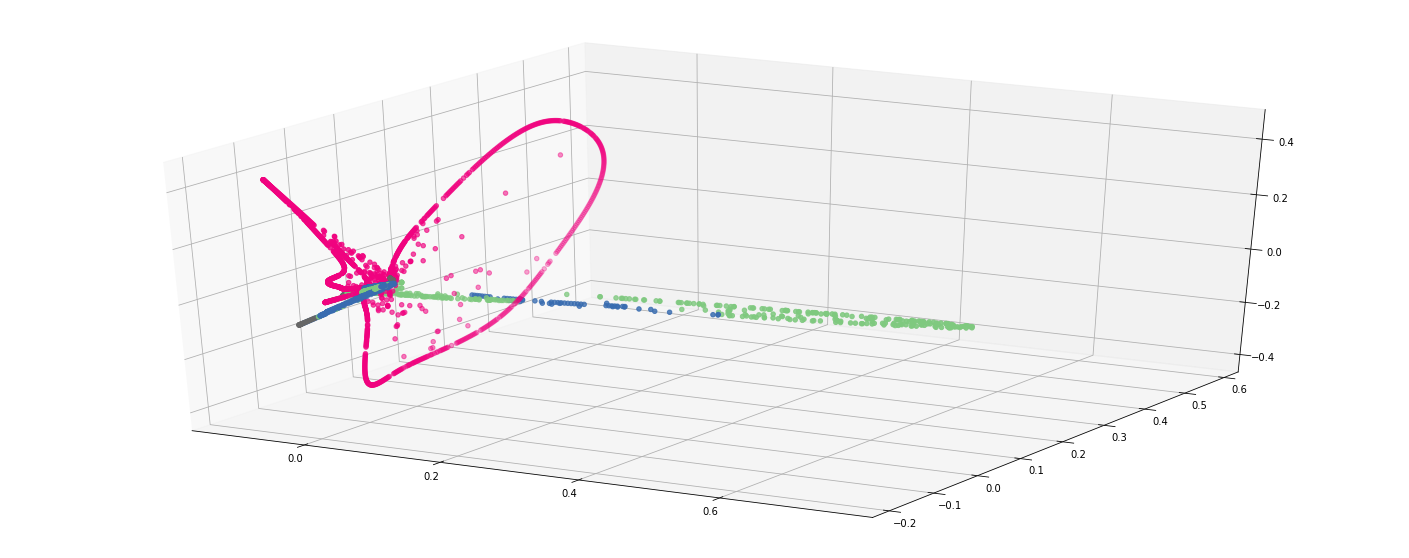

In [144]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=xs, 
           ys=ys, 
           zs=zs, 
           c=data["continent_code"],
           cmap="Accent"
          )
;

### tSNE on transformed data

In [149]:
# Applying power transform to columns to make them more Gaussian
tdata = data.select_dtypes([int, float])
tdata.fillna(0, inplace=True)

pt = PowerTransformer()
features = [feature for feature in tdata.columns if feature != "continent_code"]
for feat in features:
    pt_col = pt.fit_transform(data[[feat]])
    tdata["pt_" + feat] = pt_col

In [150]:
pt_features = [feature for feature in tdata.columns if "pt_" in feature]
tdata = tdata[pt_features + ["continent_code"]]

In [151]:
tsne_df = tdata.copy()
tsne_df.fillna(0, inplace=True)
rndperm = np.random.permutation(len(tsne_df))

In [152]:
df_subset = tsne_df.loc[rndperm,:].copy()
data_subset = df_subset.values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.52788902 0.11492773 0.09562378]


In [153]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3397 samples in 0.005s...
[t-SNE] Computed neighbors for 3397 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3397
[t-SNE] Computed conditional probabilities for sample 2000 / 3397
[t-SNE] Computed conditional probabilities for sample 3000 / 3397
[t-SNE] Computed conditional probabilities for sample 3397 / 3397
[t-SNE] Mean sigma: 0.037211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.291534
[t-SNE] KL divergence after 300 iterations: 0.612842


In [154]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['tsne-2d-three'] = tsne_results[:,2]

''

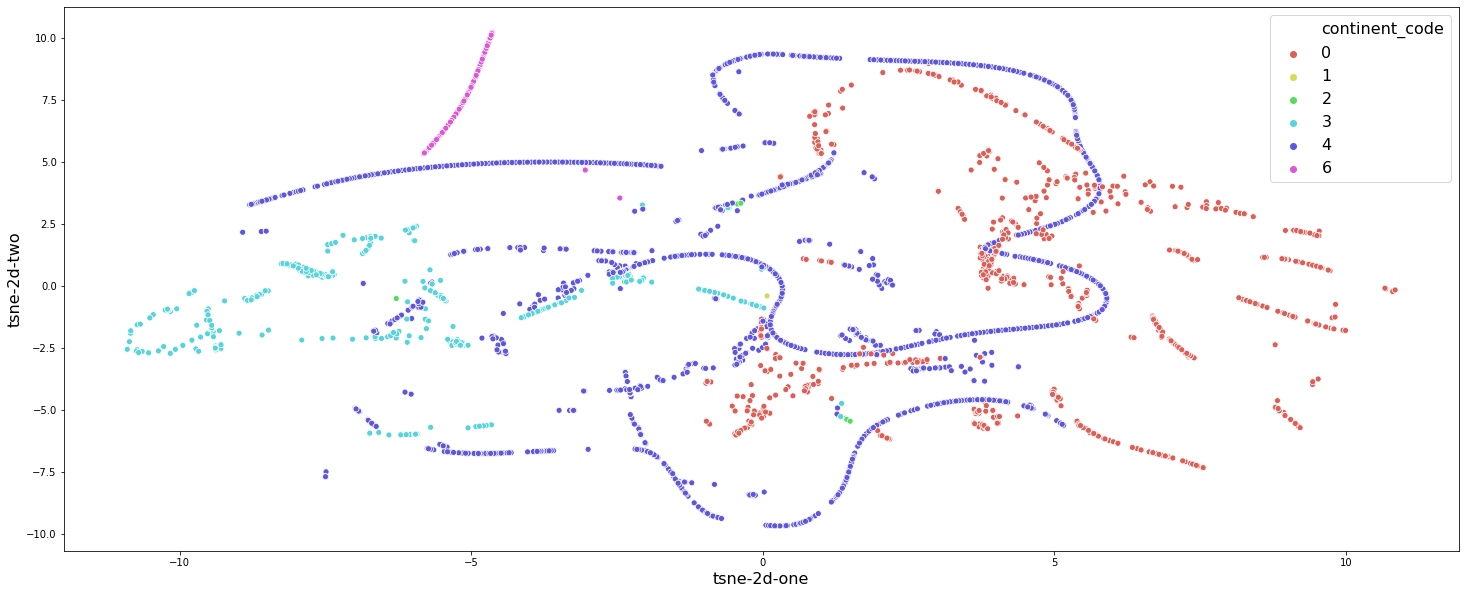

In [155]:
sns.scatterplot(x="tsne-2d-one", 
                y="tsne-2d-two",
                hue="continent_code",
                palette=sns.color_palette("hls", 6),
                data=df_subset,
                legend="full"
               )
;

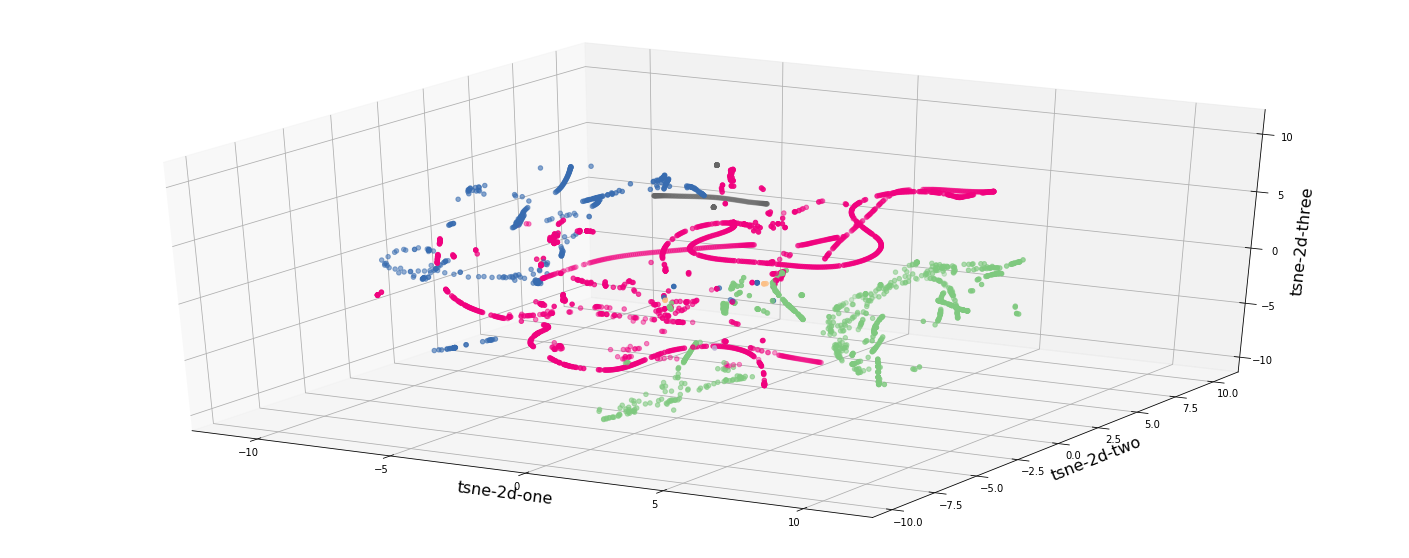

In [156]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=df_subset["tsne-2d-one"], 
           ys=df_subset["tsne-2d-two"], 
           zs=df_subset["tsne-2d-three"], 
           c=df_subset["continent_code"],
           cmap="Accent"
          );

ax.set_xlabel("tsne-2d-one");
ax.set_ylabel("tsne-2d-two");
ax.set_zlabel("tsne-2d-three");

### kPCA on transformed data

In [157]:
kpca_df = tdata.copy()
kpca_df = kpca_df.select_dtypes([int, float])
kpca_df.fillna(0, inplace=True)
X = kpca_df.drop("continent_code", axis=1)
y = kpca_df["continent_code"]

In [158]:
# Perform Kernel PCA
kernel_pca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True, gamma=1/X.shape[0])
X_kernel_pca = kernel_pca.fit_transform(X)

xs = X_kernel_pca[:, 0]
ys = X_kernel_pca[:, 1]
zs = X_kernel_pca[:, 2]

''

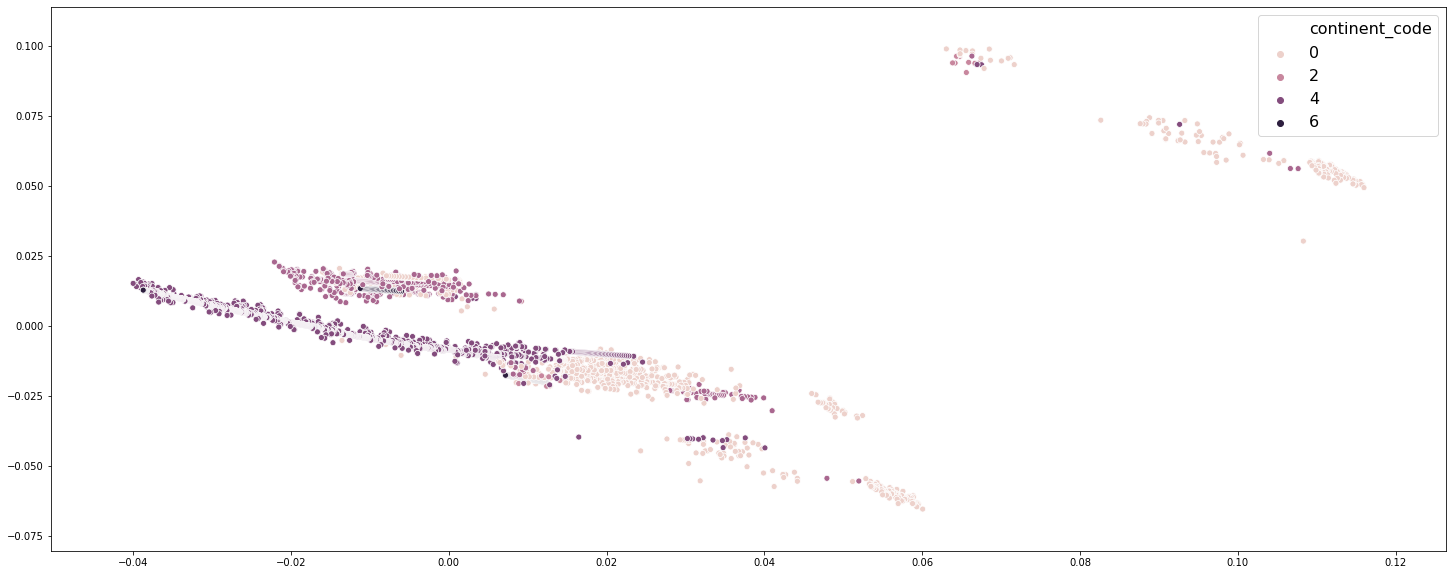

In [159]:
sns.scatterplot(x=xs, 
                y=ys, 
                hue=data["continent_code"]
               )
;

''

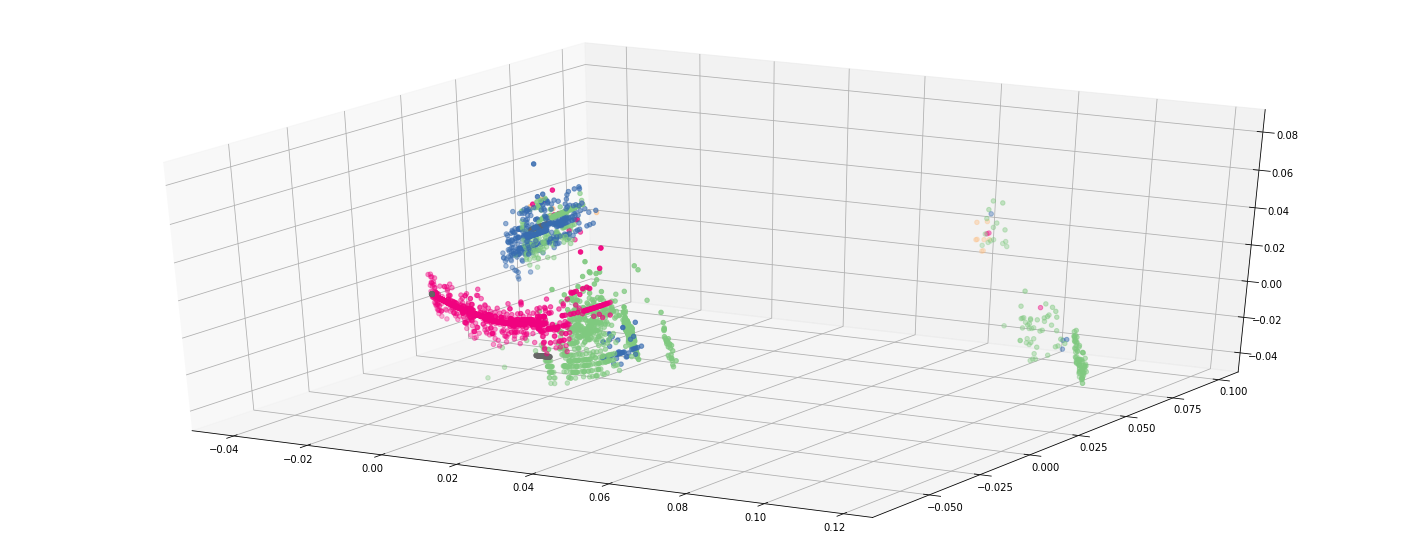

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=xs, 
           ys=ys, 
           zs=zs, 
           c=data["continent_code"],
           cmap="Accent"
          )
;

## Centrality Measures

Loosely speaking, **centrality** helps us measure the most influential nodes or vertices in a graph. Different centrality measures like degree centrality, betweenness centrality, eigenvector centrality are used to measure influence of nodes in a network.

* **Degree Centrality:** Degree centrality of a node is the fraction of the nodes it's connected to. Intuitively, the greater the degree that node can be more powerful. For example, we can think that a Twitter celebrity with 1m follower is more influential than a regular user with 100 followers.
* **Betweenness Centrality:** Betweenness centrality is a measure of centrality in a graph based on the idea of shortest path. Betweenness centrality of node *A* is the fraction of shortest paths that passes through node *A*. Nodes with high betweenness centrality works as the 'power broker' or the 'bridges' between different isolated parts of a network.
* **PageRank:** PageRank estimates a current node's importance from its linked neighbors and then again from their respective neighbors. Although popularized by Google, it can detect influential nodes in any network.
* **Eigenvector Centrality:** Eigenvector Centrality is the number of walks of infinite length ending at node $i$. This gives more importance to nodes with well-connected neighbors
* **Closeness Centrality:** Closeness centrality detects nodes that can spread information efficiently through a graph. It is inversely proportional to the sum of lengths of the shortest paths to other nodes

Here we identify the top 10 nodes according to both of the centrality measures, but they overlap a lot, presumably because it's just a co-occurance of cities and undirected. In a human social network, often the people with higher betweenness centrality are more interesting

### Degree Centrality

In [40]:
degree_centrality = nx.degree_centrality(G)

In [41]:
top10_nodes_by_centrality = sorted(degree_centrality.items(), key=lambda x:x[1], reverse=True)[:10]
top10_nodes_by_centrality

[('Wuhan', 0.18502202643171808),
 ('California', 0.059471365638766524),
 ('Baden-Wuerttemberg', 0.04625550660792952),
 ('New York', 0.04185022026431719),
 ('Washington', 0.03524229074889868),
 ('Florida', 0.030837004405286347),
 ('Colorado', 0.030837004405286347),
 ('Texas', 0.024229074889867842),
 ('New Jersey', 0.022026431718061675),
 ('Massachusetts', 0.019823788546255508)]

### Betweenness Centrality

In [42]:
betweenness_centrality = nx.betweenness_centrality(G)

In [43]:
top10_nodes_by_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x:x[1], reverse=True)[:10]
top10_nodes_by_betweenness_centrality


[('Wuhan', 0.261964840306002),
 ('California', 0.08023706130527022),
 ('Washington', 0.058360992930820955),
 ('Massachusetts', 0.04589850193826621),
 ('New York', 0.041516553807594586),
 ('Colorado', 0.03370369577520142),
 ('Florida', 0.03237416593384152),
 ('Texas', 0.027732952622091047),
 ('Illinois', 0.02445337958582989),
 ('New Jersey', 0.021776279753932398)]

### PageRank

PageRank is computed by either iteratively distributing one node's rank over tis neighbors or by randomly traversing the graph and counting the frequency of hitting each node during these walks.

In [44]:
pagerank_centrality = nx.pagerank(G)

In [45]:
top10_nodes_by_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top10_nodes_by_pagerank

[('Wuhan', 0.07744224375519498),
 ('California', 0.025454769416100746),
 ('Baden-Wuerttemberg', 0.024649320596403883),
 ('New York', 0.014861433486730465),
 ('Washington', 0.013032093508576002),
 ('Colorado', 0.01186060264973628),
 ('Florida', 0.011724097588086048),
 ('New Jersey', 0.009686516512322945),
 ('Shaanxi', 0.008674844341283978),
 ('Massachusetts', 0.008627737977523081)]

### Eigenvector Centrality

In [46]:
evec_centrality = nx.eigenvector_centrality(G)

In [47]:
top10_nodes_by_eigenvector = sorted(evec_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top10_nodes_by_eigenvector

[('Wuhan', 0.6762863213408762),
 ('California', 0.14049850768461117),
 ('Washington', 0.12446495443629815),
 ('Tokyo', 0.1100049383017931),
 ('Macau', 0.10860458897195056),
 ('Shanghai', 0.10559245692842487),
 ('Texas', 0.10296059467026328),
 ('Vancouver', 0.09471392795282772),
 ('Tianjin', 0.08861029156223123),
 ('Beijing', 0.08861029156223123)]

### Closeness Centrality

In our netowrk, this can be used to identify locations of super-spreaders of the coronavirus

In [48]:
closeness_centrality = nx.closeness_centrality(G)

In [49]:
top10_nodes_by_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top10_nodes_by_closeness


[('Wuhan', 0.2673245630605784),
 ('California', 0.2248920927335024),
 ('Washington', 0.22106414221888962),
 ('Texas', 0.20752359555834513),
 ('Rome', 0.20214036350754497),
 ('Illinois', 0.20187852365844194),
 ('Massachusetts', 0.20109705840557054),
 ('Shanghai', 0.19777946734050406),
 ('Vancouver', 0.19360275809231947),
 ('Shaanxi', 0.18687076770301822)]

## Visualizing network on world map

In [50]:
def visualize_on_map(dta):
    m = folium.Map(location=[30, 0], zoom_start=1.5)
    with open('locations3.json') as json_file:
        locs = json.load(json_file)
    for i, row in dta.iterrows():
        long1, lat1 = locs[row["location"]]
        places = GeoText(row["summary"])
        cities = set(places.cities)
        for city in cities:
            loc = [(lat1, long1)]
            if city != "Wuhan":
                long2, lat2 = locs[city]
                loc.append((lat2, long2))
                folium.PolyLine(loc, color='black', weight=0.3).add_to(m)
        if row["visiting Wuhan"] == 1 or row["from Wuhan"] == 1:
            loc = [(lat1, long1)]
            long, lat = locs["Wuhan"]
            loc.append((lat, long))
            folium.PolyLine(loc, color='black', weight=0.3).add_to(m)
    return m

In [51]:
visualize_on_map(data)

## Graph Learning and Graph Embedding

One of the limitations of graphs remains the absence of vector features. Mathematical and statistical operations on the graphs are limited and applying machine learning methods directly to graphs is challenging. Just like in NLP, we face structured data. But just like in NLP, we can learn an embedding of the graph. Several embeddings of the graph are:
* Embedding graph components (nodes, edges, etc.)
* Embedding subgraphs or whole graphs

Graph embeddings are essentially the encoding of a graph and its structure into a vector, or a set of vectors. Embedding will capture the graph topology, node-to-node relationships, and other relevant information about the graphs and its subgraphs/nodes.

After performing an embedding, we can perform task such as classification, and recommender systems.

### Node Embedding

We can encode nodes into a vector representation. We would then be able to use this embedding to perform visualizations for node predictions (i.e. predicting new connections between nodes)

For embedding graph components, let us use `Node2Vec`, an algorithmic framework for representational learning on graphs. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for different downstream machine learning tasks. This model learns low-dimensional representations for nodes by optimizing a neighborhood-preserving objective, using random walks.

First we pre-compute the probabilities and generate walks

In [173]:
### Use DGL (deep graph library)

In [103]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities: 100%|██████████| 455/455 [00:00<00:00, 9716.80it/s]


We can then embed the nodes

In [104]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

Now let us get the vector representation of a node, say "Wuhan"

In [105]:
model.wv.get_vector('Wuhan')

array([-0.33906582, -0.72025234, -3.2204113 ,  0.16015522, -1.8065319 ,
        1.2239027 ,  0.97882307,  0.46646446,  2.0031404 , -0.22992826,
       -0.5858614 , -0.5445329 ,  0.557325  , -2.2493105 , -0.36789998,
       -0.51553416, -0.37821355, -2.634439  ,  0.1421045 , -3.0928283 ,
       -0.3293004 , -1.157506  ,  0.21685827, -2.7761362 , -0.58671683,
        0.32181442,  0.32305276, -2.757086  ,  1.0430918 , -0.8068836 ,
       -1.041482  , -0.75203675, -0.41382742,  2.5218225 ,  0.2351717 ,
        1.1892625 , -0.64656395, -0.5835237 , -1.1426055 ,  1.0389503 ,
       -2.6422782 ,  0.24722677, -1.3964571 ,  1.2564635 ,  0.02412263,
        1.7655809 , -2.7486885 ,  1.9911655 , -2.3707263 , -0.19988087,
        0.79779744, -4.24928   ,  1.2007489 ,  0.06244389,  3.778979  ,
       -0.172408  , -1.0136752 ,  0.7908308 ,  1.2432511 , -2.591207  ,
       -2.0444424 , -0.32716218, -2.3905227 ,  0.9980288 ], dtype=float32)

With this embedding, one thing we can do is to find the most similar nodes, using cosine similarity between a simple mean of the projection weight vectors of the given words and the vectors for each word in the model. We return a list of these nodes, and their corresponding probabilities.

In [106]:
model.wv.most_similar('Wuhan')

[('Phillipines', 0.662682056427002),
 ('Henan', 0.6557605266571045),
 ('Kanagawa', 0.646490216255188),
 ('Wuhan, Hubei', 0.6443397998809814),
 ('Inner Mongolia', 0.6419517397880554),
 ('Ho Chi Minh City', 0.6334986686706543),
 ('Jonkoping', 0.6254032254219055),
 ('Xinjiang', 0.6254010200500488),
 ('Hunan', 0.620881974697113),
 ('Preah Sihanouk Province', 0.6176509857177734)]

### Edge Embedding

Similarly, we can also embed the edges, and the embedding can further be used for classification 

In [107]:
from node2vec.edges import HadamardEmbedder
edge_embedding = HadamardEmbedder(keyed_vectors=model.wv)

We can receive the vector representation of any edge $e$ in the graph like so

In [108]:
edge_embedding[('California', 'Wuhan')]

array([ 0.7508889 , -1.0311139 , -4.3392463 , -0.05768794, -2.1151173 ,
        2.688099  , -1.930808  ,  0.23649321,  0.6053411 ,  0.37157395,
       -0.25151014,  1.6433432 , -0.57912767, -0.31687933,  0.13298732,
       -0.16415249,  0.90053904, -1.4241952 , -0.11143937,  3.3019352 ,
        1.2619829 , -1.8482058 ,  0.1729105 , -1.6954687 , -0.27371913,
        0.04078665,  1.4684737 ,  9.267159  , -2.2749119 ,  0.06683979,
       -4.3089094 ,  1.1898289 , -0.12002429, -4.016622  , -0.16584562,
       -1.7595229 ,  3.1433156 , -1.4757407 ,  3.7097187 ,  1.3776776 ,
        7.838262  , -0.43323287,  4.99925   , -5.435686  ,  0.03195608,
        8.114085  , -1.4671631 ,  0.03999085, -2.2662055 , -0.15421467,
       -0.2865062 ,  4.3206363 , -3.2709596 ,  0.0773999 , -9.703914  ,
       -0.1866046 ,  2.0926933 , -0.07045413, -2.386211  , -1.4794054 ,
        3.591921  , -1.5517901 , -0.7307952 ,  0.9752611 ], dtype=float32)

We can also retrieve the most similar edges to any edge $e$ that exists in the graph

In [109]:
edges_keys = edge_embedding.as_keyed_vectors()
edges_keys.most_similar(str(('California', 'Wuhan')))

Generating edge features: 100%|██████████| 103740/103740.0 [00:00<00:00, 193126.76it/s]


[("('Fresno', 'Wuhan')", 0.8045440912246704),
 ("('San Mateo', 'Wuhan')", 0.8003002405166626),
 ("('Madera', 'Wuhan')", 0.7991173267364502),
 ("('San Benito', 'Wuhan')", 0.7964580655097961),
 ("('Santa Cruz', 'Wuhan')", 0.7963446974754333),
 ("('Imperial', 'Wuhan')", 0.7955495119094849),
 ("('Ventura', 'Wuhan')", 0.7904832363128662),
 ("('Riverside', 'Wuhan')", 0.7896947860717773),
 ("('Napa', 'Wuhan')", 0.7885590195655823),
 ("('Alameda', 'Wuhan')", 0.782895565032959)]

Naturally, we can see that all the edges similar to $($California, Wuhan$)$, are between Wuhan and Californian cities.

### Graph Embedding

While graphs are a meaningful, yet interpretable representation of data, we perform embeddings because
* ability to perform machine learning techniques on graphs is limited, graphs being a very small subset of machine learning
* embeddings are compressed representations
* vector operations are simpler and computationally faster

#### Deep Graph Library (DGL)

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

In [111]:
g = dgl.DGLGraph()
g.from_networkx(G)

In [112]:
# Define the message and reduce function
# NOTE: We ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [113]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = self.softmax(h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(len(g.nodes()), 5, 2)

In [114]:
inputs = torch.eye(len(g.nodes()))
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0,1])  # their labels are different

In [115]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
all_preds = []
epochs = 30

for epoch in range(epochs):
    preds = net(g, inputs)
    all_preds.append(preds)
    # we only compute loss for labeled nodes
    loss = F.cross_entropy(preds[labeled_nodes], labels)

    optimizer.zero_grad() # PyTorch accumulates gradients by default
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7054
Epoch 1 | Loss: 0.6587
Epoch 2 | Loss: 0.5745
Epoch 3 | Loss: 0.4904
Epoch 4 | Loss: 0.4210
Epoch 5 | Loss: 0.3709
Epoch 6 | Loss: 0.3396
Epoch 7 | Loss: 0.3238
Epoch 8 | Loss: 0.3172
Epoch 9 | Loss: 0.3147
Epoch 10 | Loss: 0.3138
Epoch 11 | Loss: 0.3135
Epoch 12 | Loss: 0.3133
Epoch 13 | Loss: 0.3133
Epoch 14 | Loss: 0.3133
Epoch 15 | Loss: 0.3133
Epoch 16 | Loss: 0.3133
Epoch 17 | Loss: 0.3133
Epoch 18 | Loss: 0.3133
Epoch 19 | Loss: 0.3133
Epoch 20 | Loss: 0.3133
Epoch 21 | Loss: 0.3133
Epoch 22 | Loss: 0.3133
Epoch 23 | Loss: 0.3133
Epoch 24 | Loss: 0.3133
Epoch 25 | Loss: 0.3133
Epoch 26 | Loss: 0.3133
Epoch 27 | Loss: 0.3133
Epoch 28 | Loss: 0.3133
Epoch 29 | Loss: 0.3133


In [116]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)
color = np.where(predicted_class==0, 'c', 'r')

[0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0
 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1
 1 1 0 0 0 0 0 1 0 1 0]
['c' 'c' 'r' 'r' 'c' 'c' 'c' 'c' 'c' 'c' 'r' 'c' 'c' 'c' 'r' 'c' 'c' 'r'
 'r

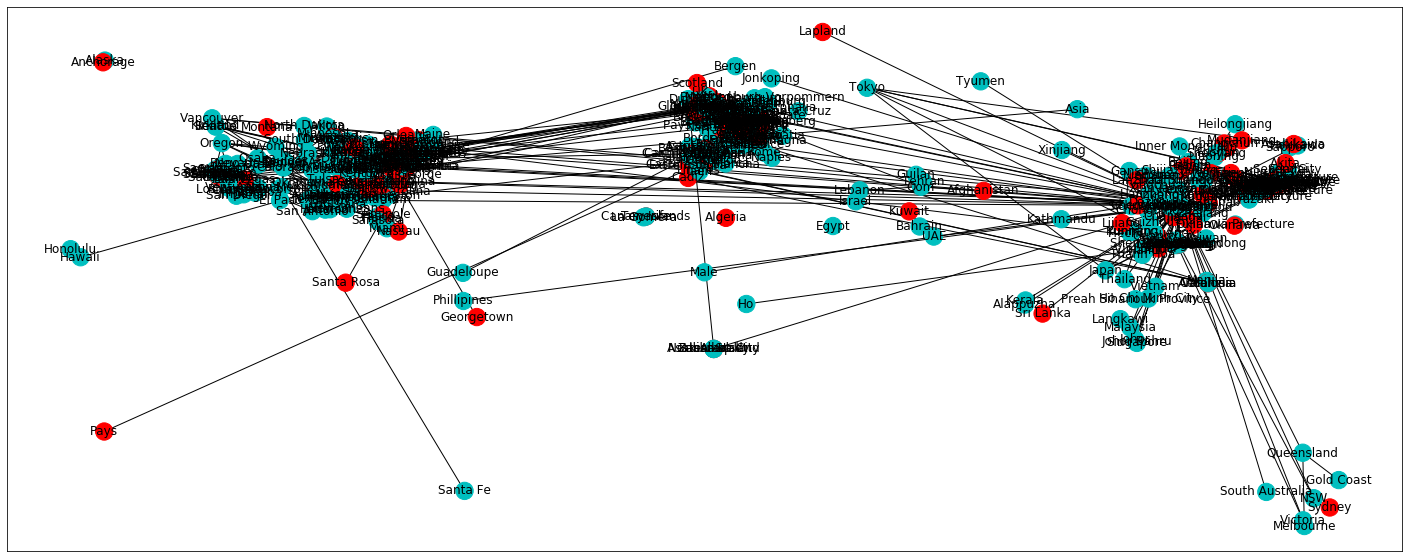

In [120]:
nx.draw_networkx(G, nx.get_node_attributes(G, 'pos'), node_color=color, with_labels=True, node_size=300)